A very quick look at the evolving coronavirus cases in LA County, starting with Jan 21st, when the first case got diagnosed in the county. Data comes from the LA County Public Health website:
http://publichealth.lacounty.gov/media/Coronavirus/
I am updating the data as it comes in. 

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import requests,datetime
from bs4 import BeautifulSoup
from datetime import timedelta


df = pd.read_csv('LACountyCovid.csv', header=0, index_col=0, squeeze=True)
df.index = pd.to_datetime(df.index)
df.index.name = 'date'


An overview of total cases (minus recovered, but including deaths) in blue, daily new cases (in red), hospitalized at the moment (so cummulative) in green, and number of deaths registered (also cummulative) - in orange

In [2]:
print(df.tail())

pop_Ro = 19530000
pop_LA = 10118759
pop_MS = 2987000
df['Ro_Conf_prop'] = df.apply(lambda row: row['RO-confirmed'] * 1000000 / pop_Ro, axis = 1) 
df['Ro_Deaths_prop'] = df.apply(lambda row: row['RO-deaths'] * 1000000 / pop_Ro, axis = 1) 
df['Ro_daily_prop'] = df.apply(lambda row: row['RO-daily'] * 1000000 / pop_Ro, axis = 1) 

df['LA_Conf_prop'] = df.apply(lambda row: row['confirmed cases'] * 1000000 / pop_LA, axis = 1) 
df['LA_Deaths_prop'] = df.apply(lambda row: row['deaths'] * 1000000 / pop_LA, axis = 1) 
df['LA_daily_prop'] = df.apply(lambda row: row['daily cases'] * 1000000 / pop_LA, axis = 1) 

df['MS_Conf_prop'] = df.apply(lambda row: row['MS-confirmed'] * 1000000 / pop_MS, axis = 1) 
df['MS_Deaths_prop'] = df.apply(lambda row: row['MS-deaths'] * 1000000 / pop_MS, axis = 1) 
df['MS_daily_prop'] = df.apply(lambda row: row['MS-daily'] * 1000000 / pop_MS, axis = 1) 
print(df.tail())

            confirmed cases  deaths  hospitalized  daily cases   month  \
date                                                                     
2020-08-07         206761.0  4967.0        1610.0       2645.0  August   
2020-08-08         208528.0  4977.0        1568.0       1789.0  August   
2020-08-09         210424.0  4996.0        1514.0       1920.0  August   
2020-08-10              NaN     NaN           NaN          NaN  August   
NaT                     NaN     NaN           NaN          NaN     NaN   

            RO-confirmed  RO-deaths  RO-hospitalized  RO-daily  MS-confirmed  \
date                                                                           
2020-08-07         57895       2566              NaN      1345       67173.0   
2020-08-08         59273       2616              NaN      1378       67649.0   
2020-08-09         60623       2659              NaN      1350           NaN   
2020-08-10         61768       2700              NaN      1145           NaN   
N

In [3]:
def scrapeGlobalCase (url):
    try:
        #url = "https://www.worldometers.info/coronavirus/"
        req = requests.get(url)
        bsObj = BeautifulSoup(req.text, "html.parser")
        data = bsObj.find_all("div",class_ = "maincounter-number")
        NumConfirmed = int(data[0].text.strip().replace(',', ''))
        NumDeaths = int(data[1].text.strip().replace(',', ''))
        NumRecovered = int(data[2].text.strip().replace(',', ''))
        NumActive = NumConfirmed - NumDeaths - NumRecovered
        TimeNow = datetime.datetime.now()
        return {
            'date': str(TimeNow),
            'ConfirmedCases': NumConfirmed,
            'ActiveCases': NumActive,
            'RecoveredCases': NumRecovered,
            'Deaths': NumDeaths
        }
    except Exception as e: print(e)




In [4]:
url_ro = "https://www.worldometers.info/coronavirus/country/romania/"
url_global = "https://www.worldometers.info/coronavirus/"
url_us = "https://www.worldometers.info/coronavirus/country/us/"
url_california = "https://www.worldometers.info/coronavirus/usa/california/"
url_ms = "https://www.worldometers.info/coronavirus/usa/mississippi/"


In [5]:
testResult = scrapeGlobalCase(url_global)
testRomania = scrapeGlobalCase(url_ro)
testUS = scrapeGlobalCase(url_us)
testCA = scrapeGlobalCase(url_california)
testMS = scrapeGlobalCase(url_ms)

In [6]:
import csv
with open('global_cases.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for key, value in testResult.items():
        writer.writerow([key, value])

In [7]:
from csv import DictWriter
def append_dict_as_row(file_name, dict_of_elem, field_names):
    # Open file in append mode
    with open(file_name, 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        dict_writer = DictWriter(write_obj, fieldnames=field_names)
        # Add dictionary as wor in the csv
        dict_writer.writerow(dict_of_elem)

In [8]:
list_global = []
cols = ['date','ConfirmedCases','ActiveCases','RecoveredCases','Deaths']
with open('global_cases_all.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        list_global.append([row['date'], row[' ConfirmedCases'], row[' ActiveCases'], row[' RecoveredCases'], row[' Deaths']])
df_global = pd.DataFrame(list_global, columns = cols)
df_global['ConfirmedCases'] = df_global['ConfirmedCases'].astype(str).astype(int)
df_global['ActiveCases'] = df_global['ActiveCases'].astype(str).astype(int)
df_global['RecoveredCases'] = df_global['RecoveredCases'].astype(str).astype(int)
df_global['Deaths'] = df_global['Deaths'].astype(str).astype(int)
df_global['DailyCases'] = df_global['ConfirmedCases'].diff(1)
df_global['DailyDeaths'] = df_global['Deaths'].diff(1)

#print(df_global.head())
#print(df_global.dtypes)

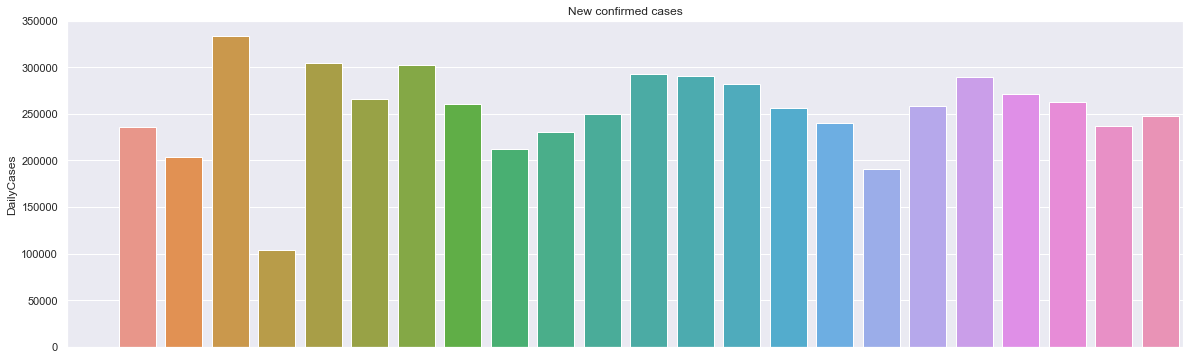

In [9]:
sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df_global.index, y = df_global['DailyCases'])
_=plt.xticks(np.arange(df_global.shape[0])[::1], df_global.index[0:0:1], rotation=35)
_=pl.set_title('New confirmed cases')

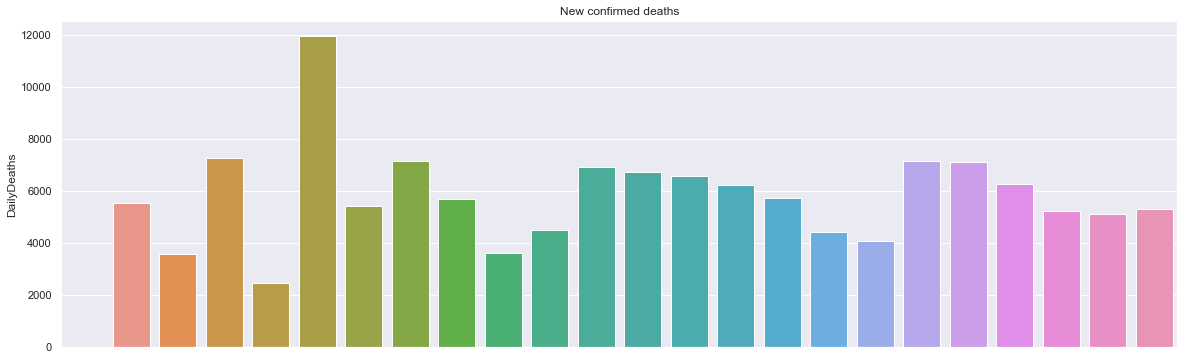

In [10]:
sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df_global.index, y = df_global['DailyDeaths'])
_=plt.xticks(np.arange(df_global.shape[0])[::1], df_global.index[0:0:1], rotation=35)
_=pl.set_title('New confirmed deaths')

Adding graphs showing cases/100000 people for each location for better comparison:
# Linear total cases per 1 000 000 people for LA County, Romania, and Mississippi 

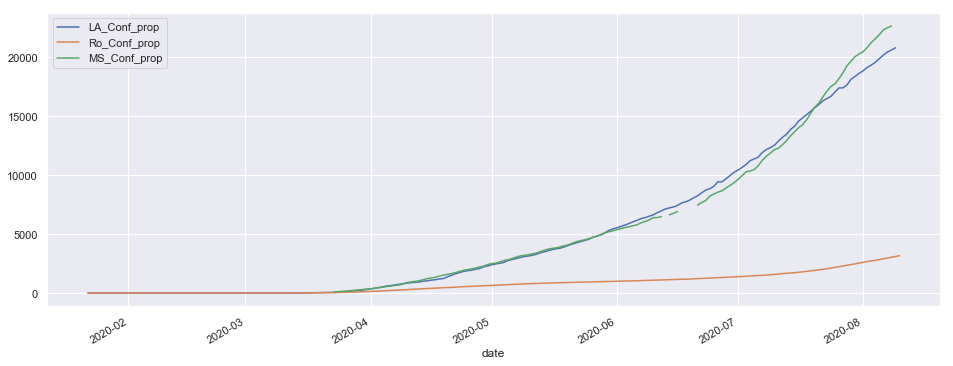

In [11]:
df[['LA_Conf_prop', 'Ro_Conf_prop', 'MS_Conf_prop']].plot(x_compat=True, figsize=(16,6))
plt.show()

# Log scale total cases per 1 000 000 people for LA County, Romania, and Mississippi 

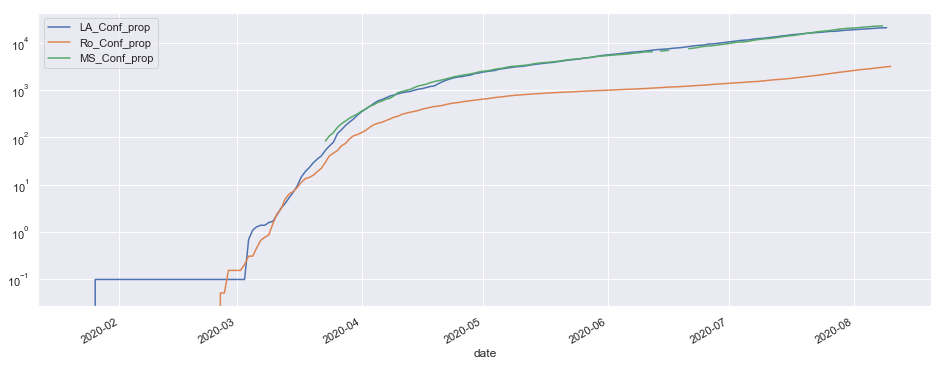

In [12]:
df[['LA_Conf_prop', 'Ro_Conf_prop', 'MS_Conf_prop']].plot(x_compat=True, figsize=(16,6))
plt.yscale('log')
plt.show()

# Linear deaths recorded per 1 000 000 people for LA County, Romania, and Mississippi 

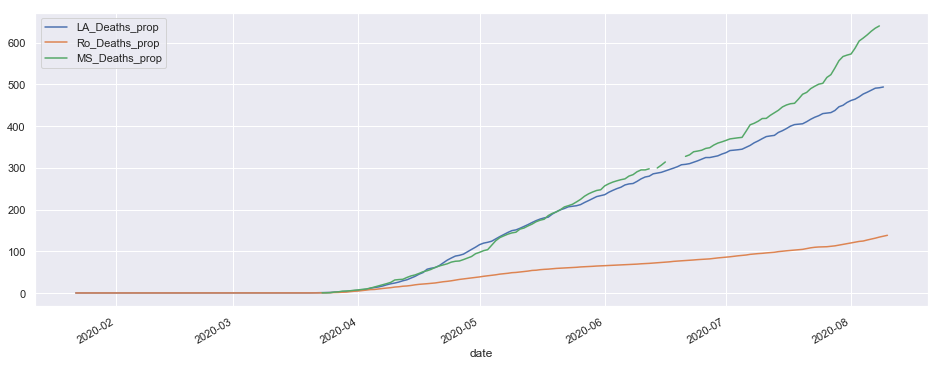

In [13]:
df[['LA_Deaths_prop', 'Ro_Deaths_prop', 'MS_Deaths_prop']].plot(x_compat=True, figsize=(16,6))
plt.show()

# Log deaths recorded per 1 000 000 people for LA County, Romania, and Mississippi 

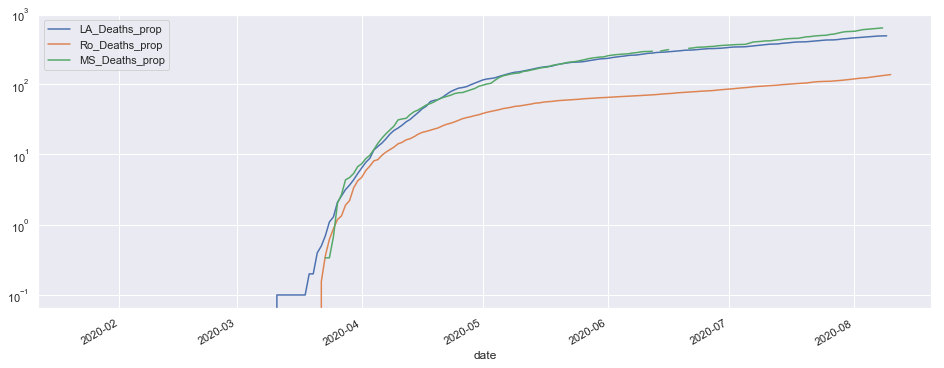

In [14]:
df[['LA_Deaths_prop', 'Ro_Deaths_prop', 'MS_Deaths_prop']].plot(x_compat=True, figsize=(16,6))
plt.yscale('log')
plt.show()

# Linear daily cases recorded per 1 000 000 people for LA County, Romania, and Mississippi 

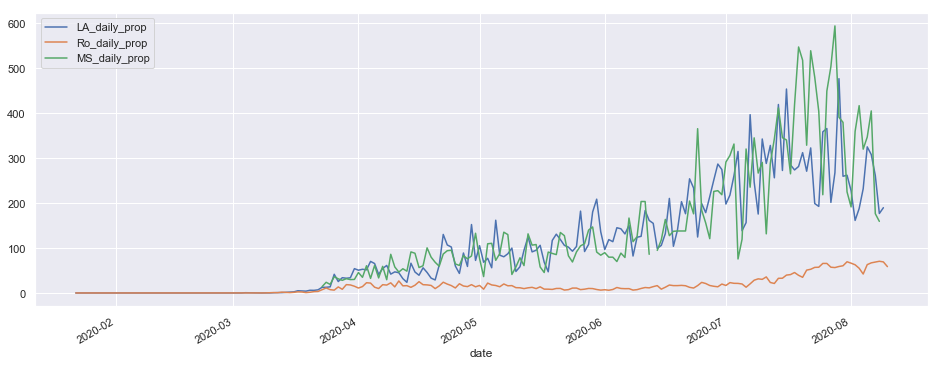

In [15]:
df[['LA_daily_prop', 'Ro_daily_prop', 'MS_daily_prop']].plot(x_compat=True, figsize=(16,6))
plt.legend(loc=2)
plt.show()

# Log daily cases recorded per 1 000 000 people for LA County, Romania, and Mississippi 

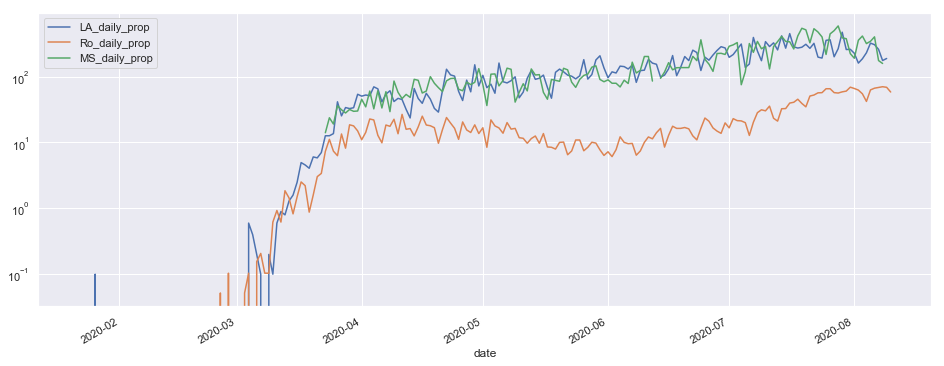

In [16]:
df[['LA_daily_prop', 'Ro_daily_prop', 'MS_daily_prop']].plot(x_compat=True, figsize=(16,6))
plt.yscale('log')
plt.show()

#                 Linear scale - all LA County data

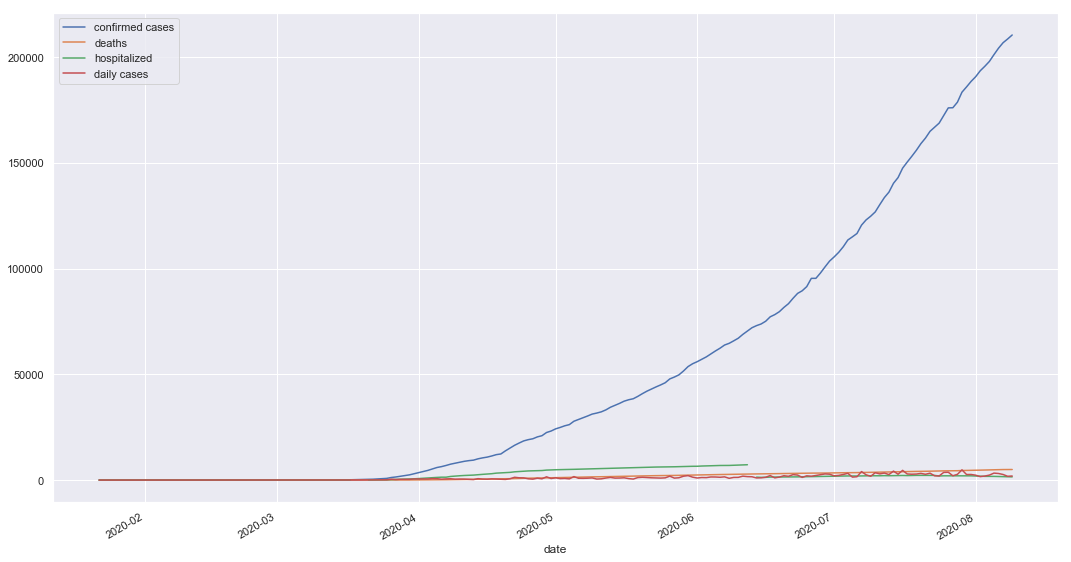

In [17]:
df_LA = df[['confirmed cases', 'deaths', 'hospitalized', 'daily cases']]
df_LA.plot(figsize=(18,10))
plt.show()

plot on a log scale to see the rate more accurately:
# Log scale - all LA County data

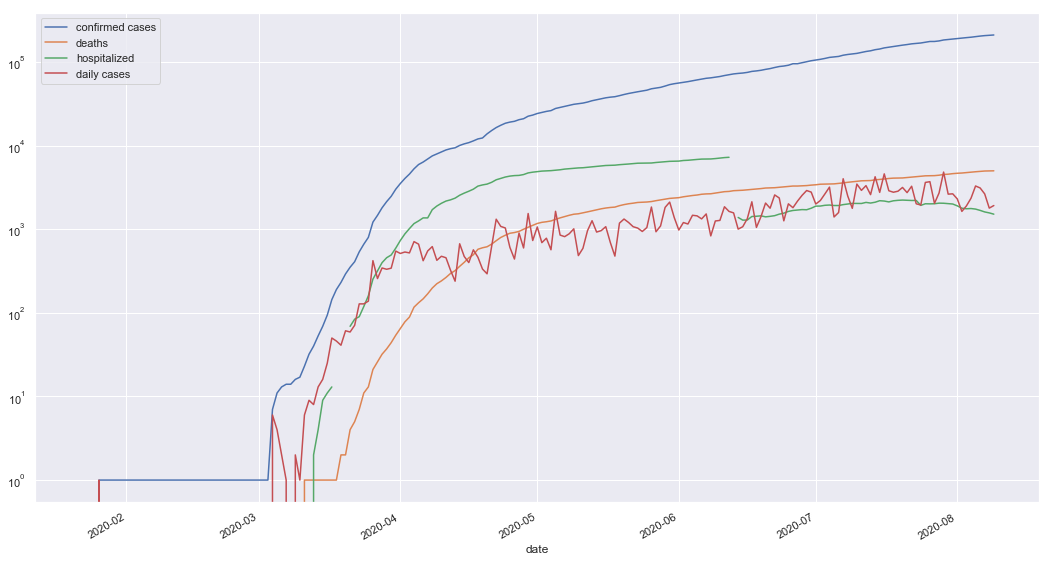

In [18]:
df_LA = df[['confirmed cases', 'deaths', 'hospitalized', 'daily cases']]
df_LA.plot(figsize=(18,10))
plt.yscale('log')
plt.show()

A closer look at just the newly diagnosed cases every day (this is the more informative curve, which shows the number of people who have been sick and contagious for at least a week before they show up in this chart). The question is how many have these people infected before being diagnosed, and how much will this curve flatten in the next 2 weeks, when we're likely to start seeing the effects of the stay at home order. Cases in LA County in blue, in Romania in orange, and Mississippi in green)

# Linear scale - comparison of cases per day for LA, RO and MS

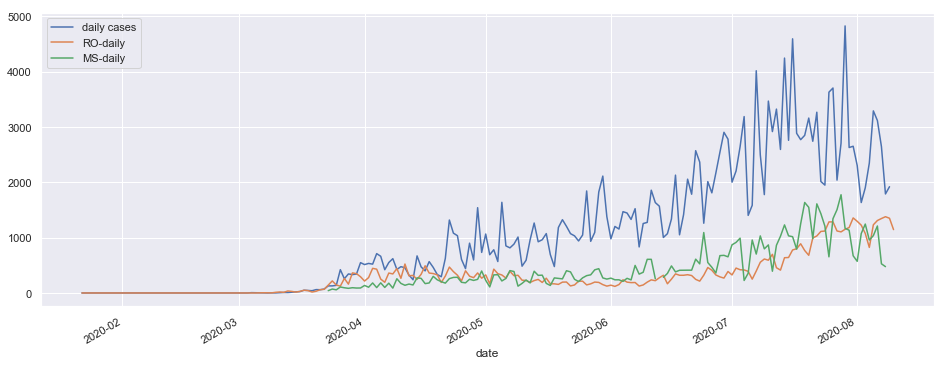

In [19]:
df[['daily cases','RO-daily', 'MS-daily']].plot(x_compat=True, figsize=(16,6))
plt.show()

# Log scale - comparison of cases per day for LA, RO and MS

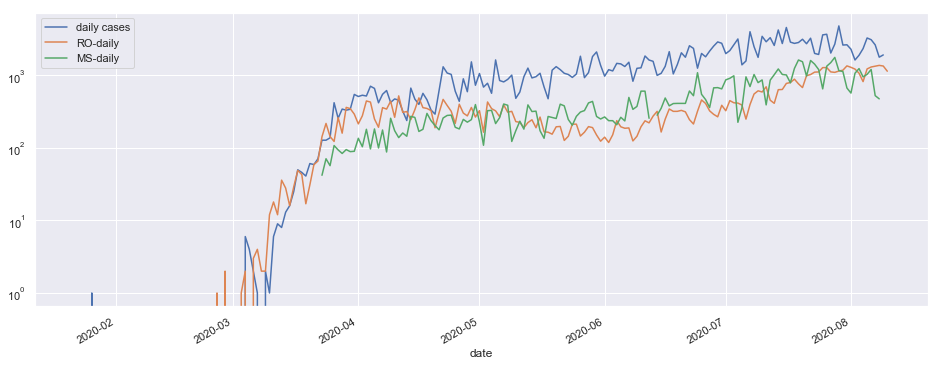

In [20]:
df[['daily cases','RO-daily', 'MS-daily']].plot(x_compat=True, figsize=(16,6))
plt.yscale('log')
plt.show()

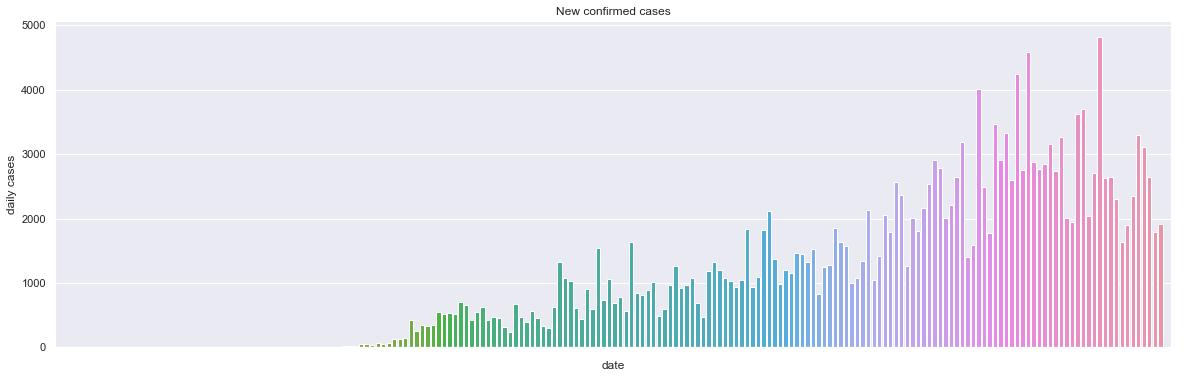

In [21]:
sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df.index, y = df['daily cases'])
_=plt.xticks(np.arange(df.shape[0])[::1], df.index[0:0:1], rotation=35)
_=pl.set_title('New confirmed cases')

Plot 7 day average for the LA County new cases:

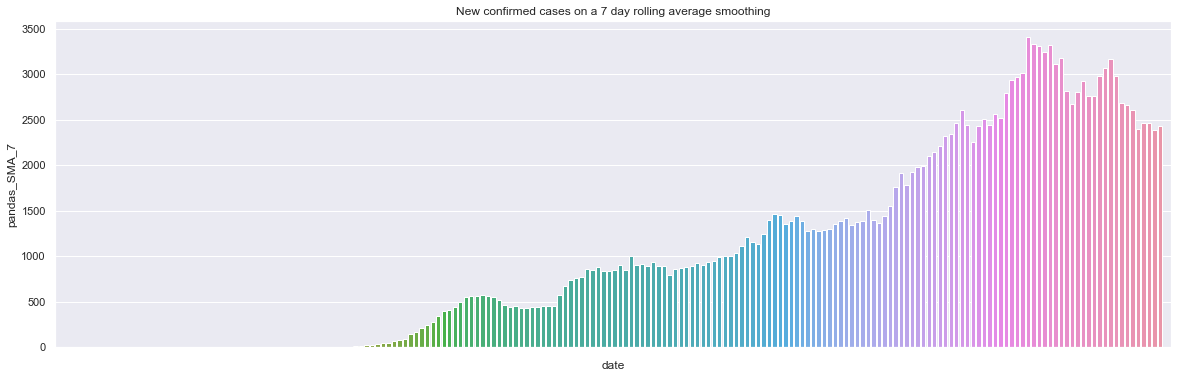

In [22]:
df['pandas_SMA_7'] = df['daily cases'].rolling(window=7).mean()
sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df.index, y = df['pandas_SMA_7'])
_=plt.xticks(np.arange(df.shape[0])[::1], df.index[0:0:1], rotation=35)
_=pl.set_title('New confirmed cases on a 7 day rolling average smoothing')

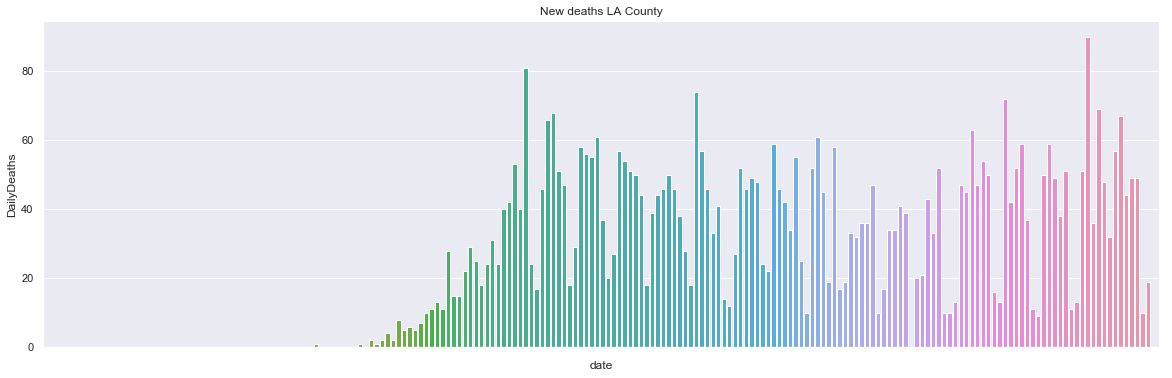

In [23]:
df['DailyDeaths'] = df['deaths'].diff(1)
sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df.index, y = df['DailyDeaths'])
_=plt.xticks(np.arange(df.shape[0])[::1], df.index[0:0:1], rotation=35)
_=pl.set_title('New deaths LA County')

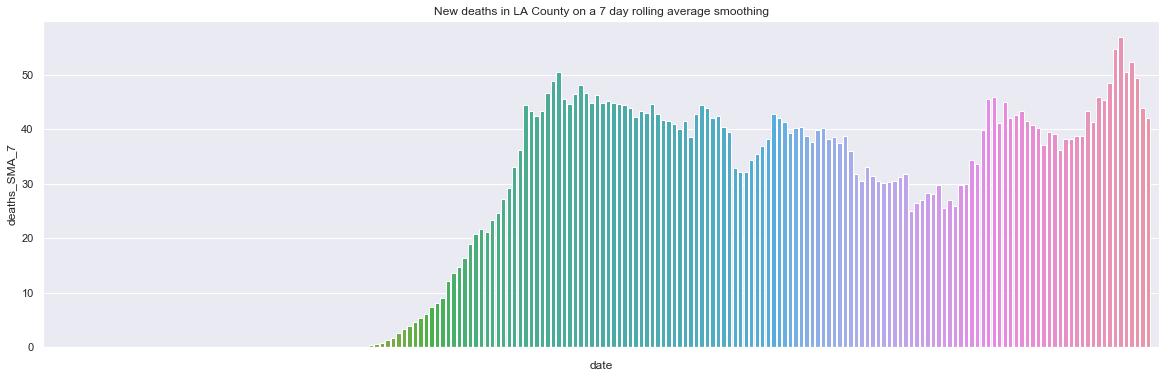

In [24]:
df['deaths_SMA_7'] = df['DailyDeaths'].rolling(window=7).mean()
sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df.index, y = df['deaths_SMA_7'])
_=plt.xticks(np.arange(df.shape[0])[::1], df.index[0:0:1], rotation=35)
_=pl.set_title('New deaths in LA County on a 7 day rolling average smoothing')

Nu am gasit date despre numarul de spitalizari in Romania - de aceea lipseste curba respectiva dupa data de 25 Martie.
# Linear scale - all data for Romania cases 

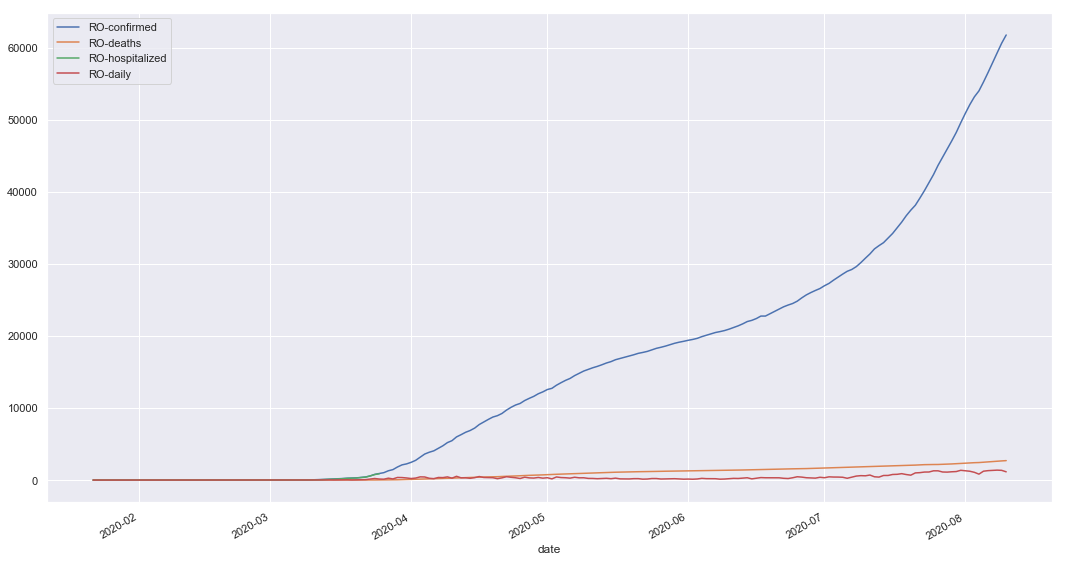

            RO-confirmed  RO-deaths  RO-hospitalized  RO-daily
date                                                          
2020-08-07         57895       2566              NaN      1345
2020-08-08         59273       2616              NaN      1378
2020-08-09         60623       2659              NaN      1350
2020-08-10         61768       2700              NaN      1145
NaT                62547       2729              NaN       779


In [25]:
df_RO = df[['RO-confirmed', 'RO-deaths', 'RO-hospitalized', 'RO-daily']]
df_RO.plot(figsize=(18,10))
plt.show()
print(df_RO.tail())

# Log scale - all data for Romania cases 

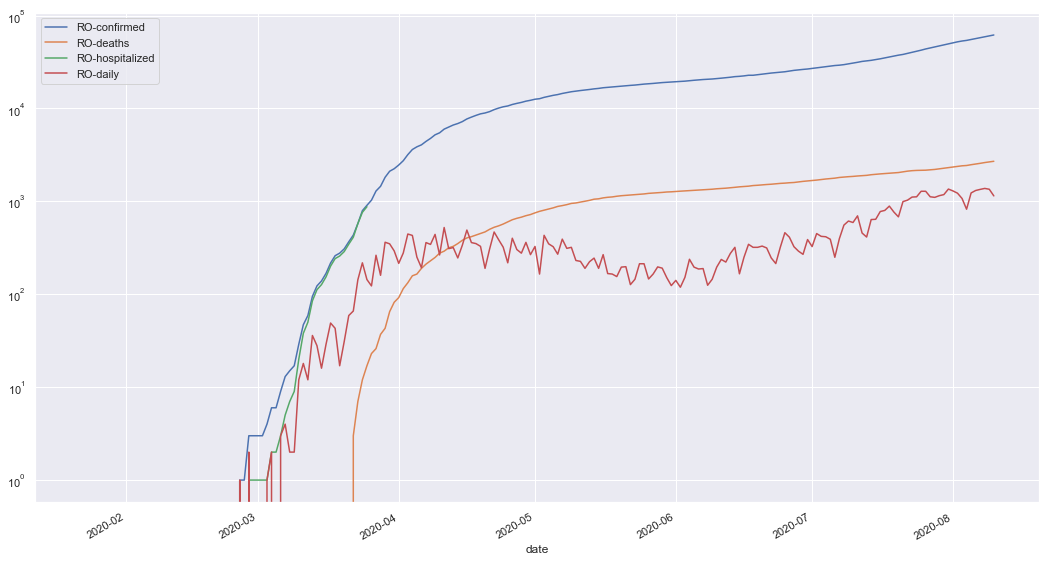

In [26]:
df_RO = df[['RO-confirmed', 'RO-deaths', 'RO-hospitalized', 'RO-daily']]
df_RO.plot(figsize=(18,10))
plt.yscale('log')
plt.show()

Comparison LA County(total population 10 105 000 people) to Romania (population 19 500 000) as of 2018.  Starting with total confirmed cases:
Adding Mississippi - population of 3 980 000.

# Linear scale - all data for Mississippi cases 

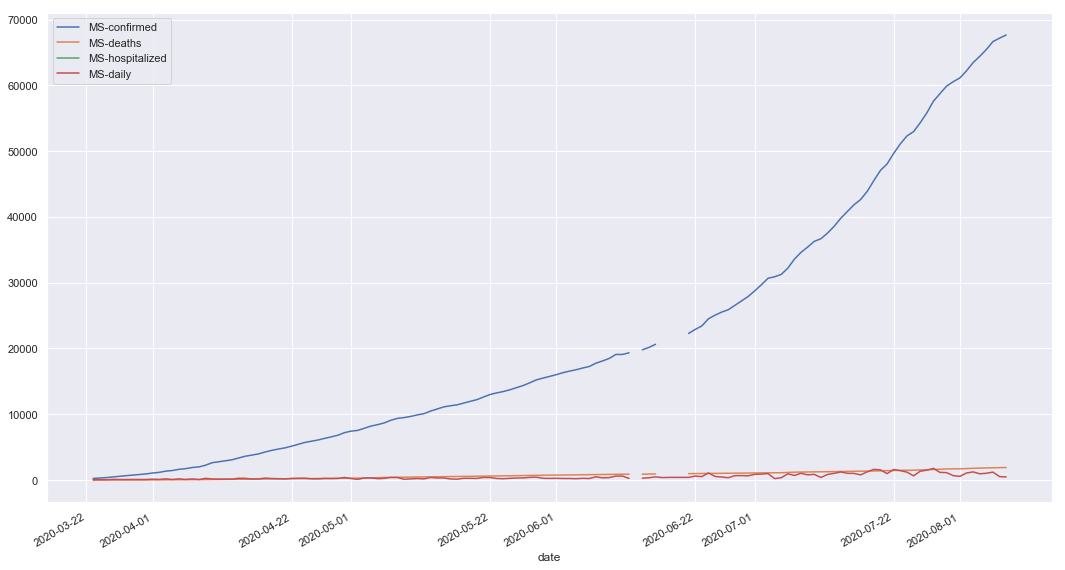

In [27]:
df_MS = df[['MS-confirmed', 'MS-deaths', 'MS-hospitalized', 'MS-daily']]
df_MS.plot(figsize=(18,10))
plt.show()

# Log scale - all data for Mississippi cases 

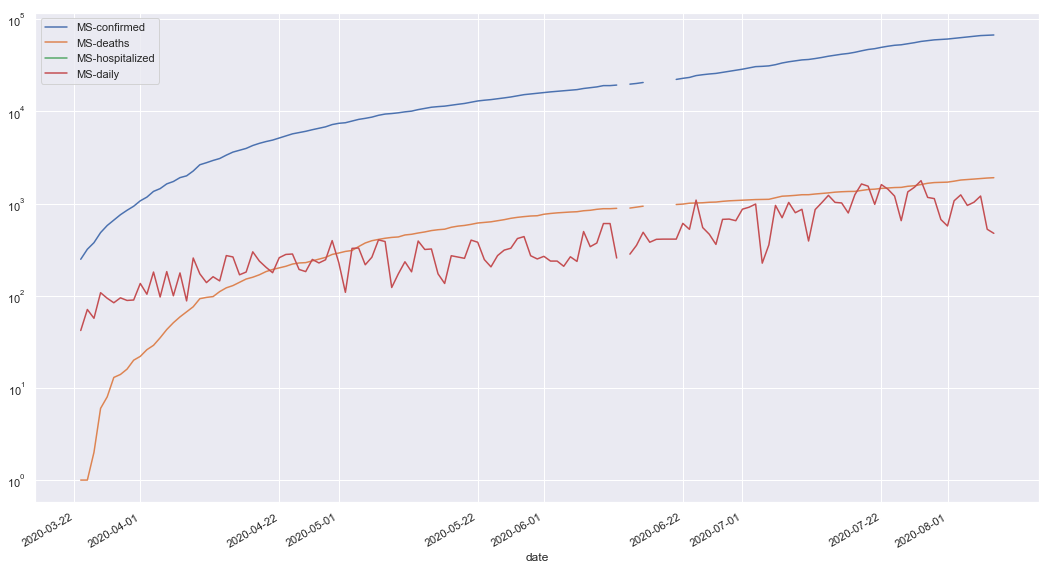

In [28]:
df_MS = df[['MS-confirmed', 'MS-deaths', 'MS-hospitalized', 'MS-daily']]
df_MS.plot(figsize=(18,10))
plt.yscale('log')
plt.show()

# Linear scale - comparison data for all confirmed cases to date for LA, MS and RO

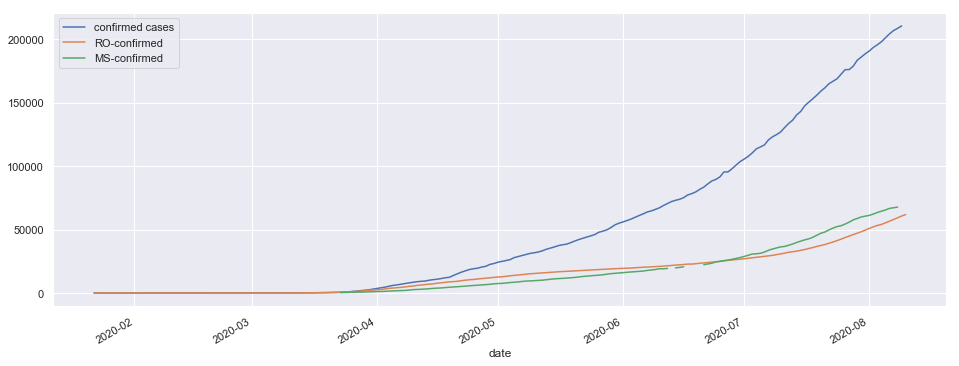

In [29]:
df[['confirmed cases','RO-confirmed', 'MS-confirmed']].plot(x_compat=True, figsize=(16,6))

plt.show()

# Log scale - comparison data for all confirmed cases to date for LA, MS and RO

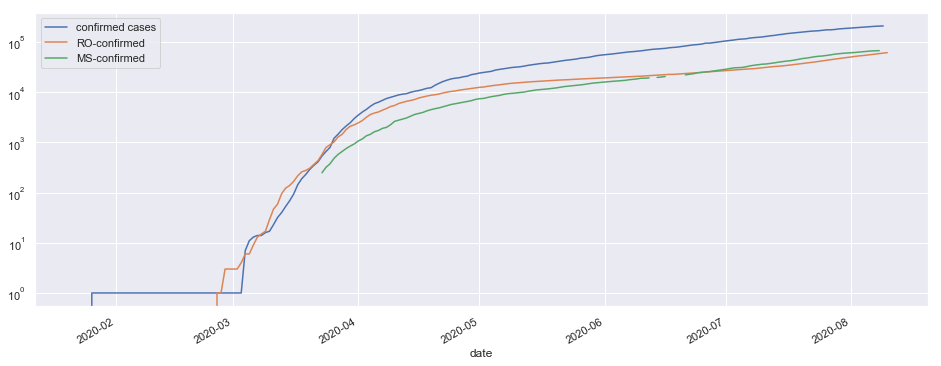

In [30]:
df[['confirmed cases','RO-confirmed', 'MS-confirmed']].plot(x_compat=True, figsize=(16,6))
plt.yscale('log')
plt.show()

Comparison of number of deaths (cummulative) between LA County (blue curve) and Romania (orange curve). Adding Mississippi
# Linear scale - comparison data for all deaths to date for LA, MS and RO

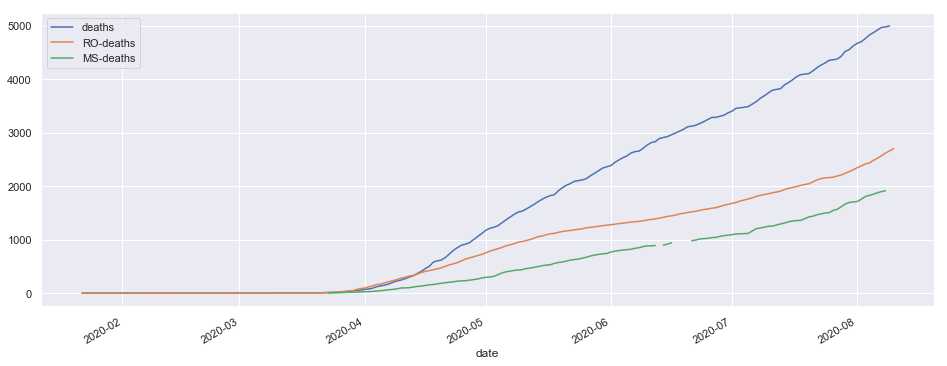

In [31]:
df[['deaths','RO-deaths', 'MS-deaths']].plot(x_compat=True, figsize=(16,6))

plt.show()

# Log scale - comparison data for all deaths to date for LA, MS and RO

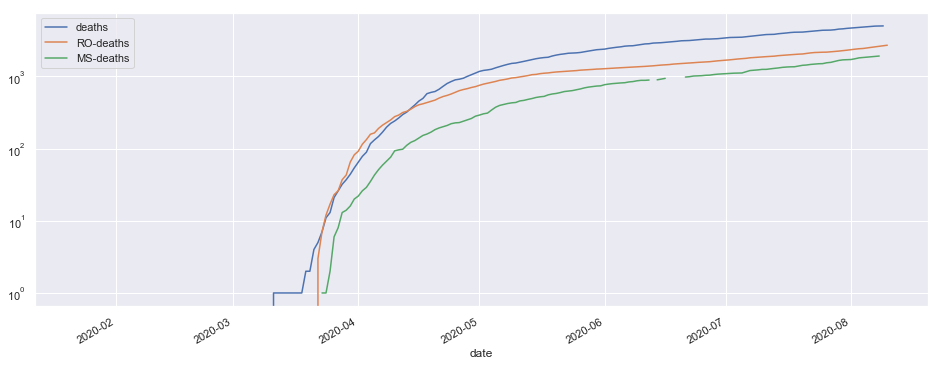

In [32]:
df[['deaths','RO-deaths', 'MS-deaths']].plot(x_compat=True, figsize=(16,6))
plt.yscale('log')
plt.show()

In [33]:
import requests,datetime
from bs4 import BeautifulSoup
from datetime import timedelta
  
URL = "http://publichealth.lacounty.gov/media/Coronavirus/"

r = requests.get(URL)  
soup = BeautifulSoup(r.content, 'html5lib') 
the_text = soup.get_text()
st_date = the_text
date_md = [int(s) for s in st_date.split() if s.isdigit()]
#print(soup.prettify())  
new_data = []
table = soup.findAll('div', attrs = {'class':'counter-block counter-text'})



In [34]:
field_names = ['date','ConfirmedCases','ActiveCases','RecoveredCases','Deaths']
field_LA = ['confirmed cases', 'deaths', 'hospitalized', 'daily cases']
field_RO = ['RO-confirmed', 'RO-deaths', 'RO-hospitalized', 'RO-daily']
field_MS = ['MS-confirmed', 'MS-deaths', 'MS-hospitalized', 'MS-daily']
# Append a dict as a row in csv file
append_dict_as_row('global_cases_all.csv', testResult, field_names)
append_dict_as_row('global_cases_us.csv', testUS, field_names)
append_dict_as_row('global_cases_ro.csv', testRomania, field_names)
append_dict_as_row('global_cases_ca.csv', testCA, field_names)
append_dict_as_row('global_cases_ms.csv', testMS, field_names)


In [35]:
list_ro = []
cols = ['date','ConfirmedCases','ActiveCases','RecoveredCases','Deaths']
with open('global_cases_ro.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        list_ro.append([row['date'], row[' ConfirmedCases'], row[' ActiveCases'], row[' RecoveredCases'], row[' Deaths']])
df_ro = pd.DataFrame(list_ro, columns = cols)
df_ro['ConfirmedCases'] = df_ro['ConfirmedCases'].astype(str).astype(int)
df_ro['ActiveCases'] = df_ro['ActiveCases'].astype(str).astype(int)
df_ro['RecoveredCases'] = df_ro['RecoveredCases'].astype(str).astype(int)
df_ro['Deaths'] = df_ro['Deaths'].astype(str).astype(int)
df_ro['DailyCases'] = df_ro['ConfirmedCases'].diff(1)
df_ro['DailyDeaths'] = df_ro['Deaths'].diff(1)

df_ro.tail()

,date,ConfirmedCases,ActiveCases,RecoveredCases,Deaths,DailyCases,DailyDeaths
20,2020-08-06 22:25:17.459207,57895,26337,28992,2566,1345.0,45.0
21,2020-08-07 17:23:06.738810,59273,27368,29289,2616,1378.0,50.0
22,2020-08-08 14:47:07.906955,60623,28092,29872,2659,1350.0,43.0
23,2020-08-09 16:41:51.368122,61768,28949,30119,2700,1145.0,41.0
24,2020-08-10 18:03:18.867614,62547,29507,30311,2729,779.0,29.0


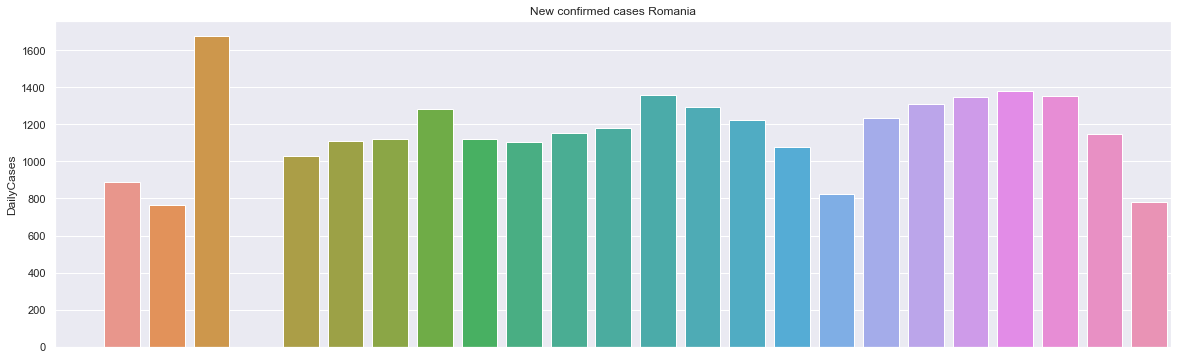

In [36]:
sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df_ro.index, y = df_ro['DailyCases'])
_=plt.xticks(np.arange(df_ro.shape[0])[::1], df_ro.index[0:0:1], rotation=35)
_=pl.set_title('New confirmed cases Romania')

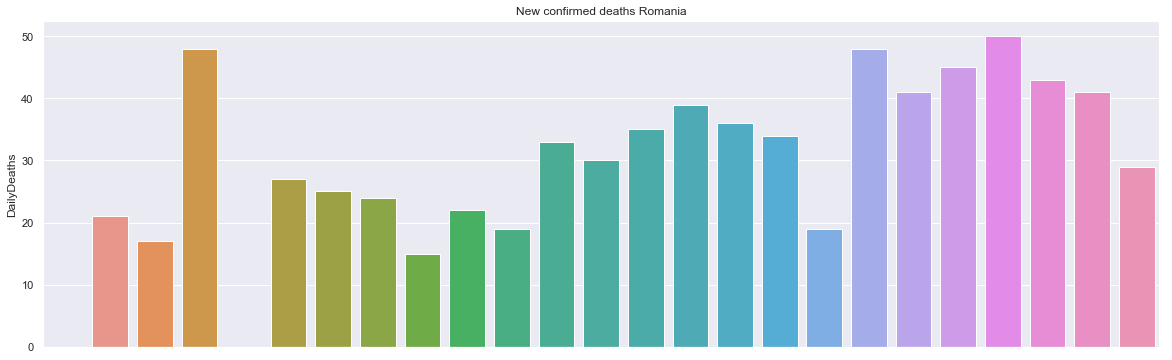

In [37]:
sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df_ro.index, y = df_ro['DailyDeaths'])
_=plt.xticks(np.arange(df_ro.shape[0])[::1], df_ro.index[0:0:1], rotation=35)
_=pl.set_title('New confirmed deaths Romania')

In [42]:
list_ca = []
cols = ['date','ConfirmedCases','ActiveCases','RecoveredCases','Deaths']
with open('global_cases_ca.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        list_ca.append([row['date'], row[' ConfirmedCases'], row[' ActiveCases'], row[' RecoveredCases'], row[' Deaths']])
df_ca = pd.DataFrame(list_ca, columns = cols)
df_ca['ConfirmedCases'] = df_ca['ConfirmedCases'].astype(str).astype(int)
df_ca['ActiveCases'] = df_ca['ActiveCases'].astype(str).astype(int)
df_ca['RecoveredCases'] = df_ca['RecoveredCases'].astype(str).astype(int)
df_ca['Deaths'] = df_ca['Deaths'].astype(str).astype(int)
df_ca['DailyCases'] = df_ca['ConfirmedCases'].diff(1)
df_ca['DailyDeaths'] = df_ca['Deaths'].diff(1)

df_ca.tail()

,date,ConfirmedCases,ActiveCases,RecoveredCases,Deaths,DailyCases,DailyDeaths
15,2020-08-08 14:35:14.118427,555100,330380,214416,10304,6031.0,97.0
16,2020-08-08 14:47:09.708839,555100,330380,214416,10304,0.0,0.0
17,2020-08-09 16:36:39.948961,562604,336048,216178,10378,7504.0,74.0
18,2020-08-09 16:41:52.411579,562604,336048,216178,10378,0.0,0.0
19,2020-08-10 18:03:19.643842,573773,339971,223334,10468,11169.0,90.0


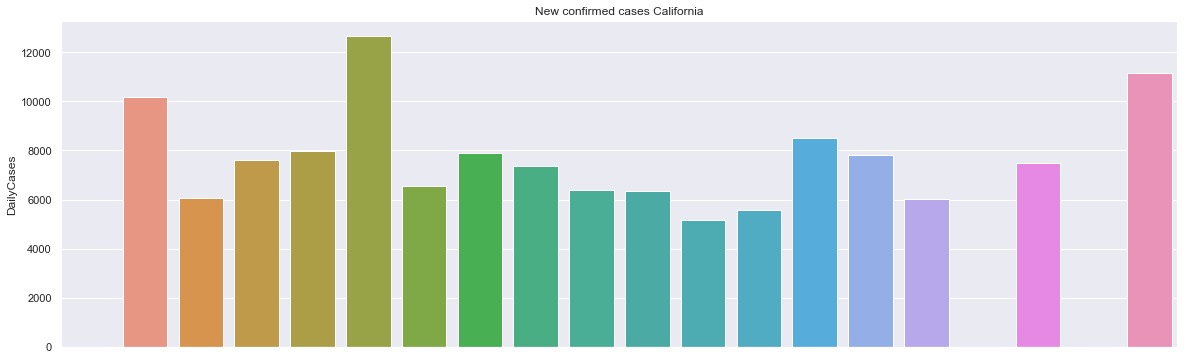

In [39]:
sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df_ca.index, y = df_ca['DailyCases'])
_=plt.xticks(np.arange(df_ca.shape[0])[::1], df_ca.index[0:0:1], rotation=35)
_=pl.set_title('New confirmed cases California')

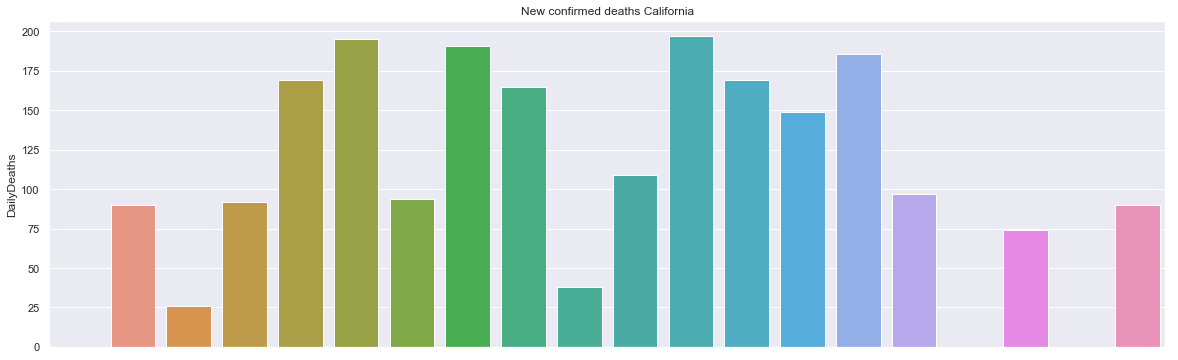

In [40]:
sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df_ca.index, y = df_ca['DailyDeaths'])
_=plt.xticks(np.arange(df_ca.shape[0])[::1], df_ca.index[0:0:1], rotation=35)
_=pl.set_title('New confirmed deaths California')

In [41]:

from datetime import timedelta
  
URL = "http://publichealth.lacounty.gov/media/Coronavirus/"

r = requests.get(URL)  
soup = BeautifulSoup(r.content, 'html5lib') 
the_text = soup.get_text()
st_date = the_text
date_md = [int(s) for s in st_date.split() if s.isdigit()]
#print(soup.prettify())  
new_data = []
table = soup.findAll('div', attrs = {'class':'counter-block counter-text'})
#dt_txt = soup.find('div', attrs = {'class': 'col-md-12 center'})
#all_text = dt_txt.get_text()
#new_dt = [int(s) for s in all_text.split() if s.isdigit()]
#print(new_dt)
#if len(table) > 2:
#    print('Need to take a look, format of page has changed')
#for row in table: 
#    print(row.text)
#    new_data.append(int(row.text))
     
#print(new_data)


TO DO: 
    1. improve and fix scrapers for data
    2. plot 7 day averages
    3. build prediction models